In [81]:
import os
import numpy as np
import datetime
from tensorflow_core.python.keras.callbacks import EarlyStopping
from tensorflow_core.python.keras.utils import np_utils
from tensorflow_core.python.keras.models import Sequential
from tensorflow_core.python.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.python import math_ops
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow_core.python.keras.layers import Activation
from tensorflow_core.python.keras.utils import get_custom_objects   # 自定義gelu

np.random.seed(10)

In [82]:
Tr_ver = 'orig_50_M_librosa_'
Te_ver = 'orig_50_M_librosa_'

Tr_ver = 'pe_50_M_librosa_'
Te_ver = 'pe_50_M_librosa_'

Tr_ver = 'pe_50_librosa_'
Te_ver = 'pe_50_librosa_'

Tr_ver += '2_'
Te_ver += '2_'

shape = 50

now_path = r'D:\TIMITDIC_231101'
data_path = now_path + '_data_AIS'

Tr_CDF_path = os.path.join(data_path, 'TRAIN', 'cnn_dataset')
Te_CDF_path = os.path.join(data_path, 'TEST', 'cnn_dataset')

Tr_DS_path = os.path.join(Tr_CDF_path, 'mfcc', Tr_ver + 'SoundDataset.npz')

Te_DS_path = os.path.join(Te_CDF_path, 'mfcc', Te_ver + 'SoundDataset.npz')

In [83]:
Tr_DS = np.load(Tr_DS_path)
Te_DS = np.load(Te_DS_path)

train_value, train_label = Tr_DS['TrainValue'], Tr_DS['TrainLabel_class']
test_value, test_label = Te_DS['TestValue'], Te_DS['TestLabel_class']
# test_value, test_label, test_label2 = Te_DS['TestValue'], Te_DS['TestLabel_class'], Te_DS['TestLabel_type']

train_value_4D = train_value.reshape(train_value.shape[0], shape, shape, 1).astype('float32')
test_value_4D = test_value.reshape(test_value.shape[0], shape, shape, 1).astype('float32')

# 向量轉換為二進制(只有0和1)的矩陣類型
# 但train_label、test_label原先資料就都是0跟1?
train_label_OneHot = np_utils.to_categorical(train_label)
test_label_OneHot = np_utils.to_categorical(test_label)

In [84]:
class Davis( Activation ):    
    def __init__(self, activation, **kwargs):
        super(Davis, self).__init__(activation, **kwargs)
        self.__name__ = 'custom_gelu'

def custom_gelu(x):
    return 0.5 * x * (1 + math_ops.tanh(math_ops.sqrt(2 / np.pi) * (x + 0.044715 * math_ops.pow(x, 3))))

get_custom_objects().update({'custom_gelu': Davis(custom_gelu)})
get_custom_objects().update({'Davis': (Activation)})

In [85]:
activation_cate = 'relu'
# activation_cate = 'custom_gelu'
# activation_cate = 'sigmoid'
# activation_cate = 'elu'
# activation_cate = 'tanh'
kernel_size = 3

model = Sequential()
model.add(Conv2D(32, (kernel_size, kernel_size), input_shape=(shape, shape, 1), padding='same', activation=activation_cate))
model.add(Conv2D(32, (kernel_size, kernel_size), padding='same', activation=activation_cate))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(32, (kernel_size, kernel_size), padding='same', activation=activation_cate))
model.add(Conv2D(64, (kernel_size, kernel_size), padding='same', activation=activation_cate))
# model.add(Conv2D(128, (3, 3), padding='same', activation='custom_gelu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='custom_gelu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation=activation_cate))
# model.add(Dropout(0.2))
model.add(Dense(128, activation=activation_cate))
model.add(Dropout(0.5))
# model.add(Dense(32, activation=activation_cate))
# model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [86]:
model.summary()
model.compile(loss='binary_crossentropy',  # mean_squared_error, binary_crossentropy, categorical_crossentropy
              optimizer="adam",  # sgd, rmsprop, adam
              metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 50, 50, 32)        320       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 25, 25, 32)        9248      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 64)       

In [87]:
# 創建一個早停法的回調函數
# early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
# early_stopping = EarlyStopping(monitor='val_acc', patience=100, restore_best_weights=True)

train_history=model.fit(x=train_value_4D,
                        y=train_label_OneHot,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=10,
                        verbose=2,
                        # callbacks=[early_stopping])
                        )

Train on 310 samples, validate on 78 samples
Epoch 1/100
310/310 - 2s - loss: 0.6019 - acc: 0.6602 - val_loss: 0.5873 - val_acc: 0.6667
Epoch 2/100
310/310 - 1s - loss: 0.5692 - acc: 0.6903 - val_loss: 0.5113 - val_acc: 0.8291
Epoch 3/100
310/310 - 1s - loss: 0.4331 - acc: 0.8054 - val_loss: 0.3290 - val_acc: 0.8120
Epoch 4/100
310/310 - 1s - loss: 0.2862 - acc: 0.8828 - val_loss: 0.1732 - val_acc: 0.8974
Epoch 5/100
310/310 - 1s - loss: 0.1937 - acc: 0.9140 - val_loss: 0.1379 - val_acc: 0.8974
Epoch 6/100
310/310 - 1s - loss: 0.1623 - acc: 0.9280 - val_loss: 0.1101 - val_acc: 0.9701
Epoch 7/100
310/310 - 1s - loss: 0.1484 - acc: 0.9452 - val_loss: 0.1119 - val_acc: 0.9744
Epoch 8/100
310/310 - 1s - loss: 0.0898 - acc: 0.9677 - val_loss: 0.0988 - val_acc: 0.9658
Epoch 9/100
310/310 - 1s - loss: 0.1289 - acc: 0.9505 - val_loss: 0.0715 - val_acc: 0.9744
Epoch 10/100
310/310 - 1s - loss: 0.1153 - acc: 0.9538 - val_loss: 0.0864 - val_acc: 0.9658
Epoch 11/100
310/310 - 1s - loss: 0.0927 - a

{'loss': [0.6019048258181541, 0.569213125013536, 0.43313630021387534, 0.2861749374217564, 0.19374277358574252, 0.16227625412566046, 0.1484031313729863, 0.08978404930882877, 0.12892207097742828, 0.1153365996433422, 0.09273646454957704, 0.09723696123523216, 0.18366973513677234, 0.09096910810518649, 0.05165040615928217, 0.08318966657468756, 0.06538939016031838, 0.04577849982325138, 0.03596426969564955, 0.04828713201694031, 0.051449558960044786, 0.041738337731775606, 0.02613893793621232, 0.022646398467677208, 0.015841722713180535, 0.012444577935015801, 0.009297210656115803, 0.01113269981647509, 0.009068977823626733, 0.014757588787731153, 0.014061858589580043, 0.01293374242022109, 0.013456268445888864, 0.008959090163948705, 0.010232755292493392, 0.004679871006328173, 0.0025135033017171793, 0.003064668633649672, 0.001874584997239513, 0.0017312723269501504, 0.00517743690658262, 0.020107255884207073, 0.04853241221186885, 0.026031521330234075, 0.006391169505494171, 0.007177530701881555, 0.01598

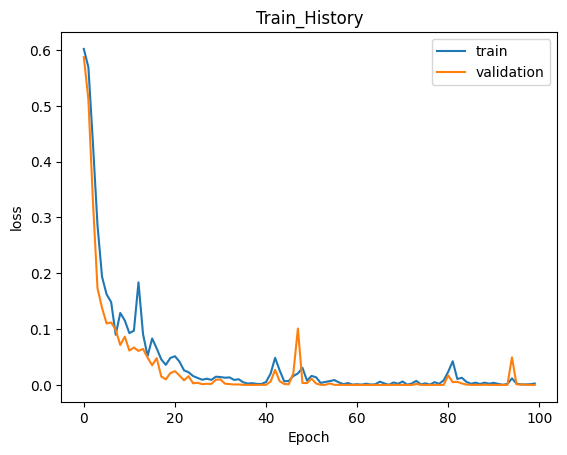

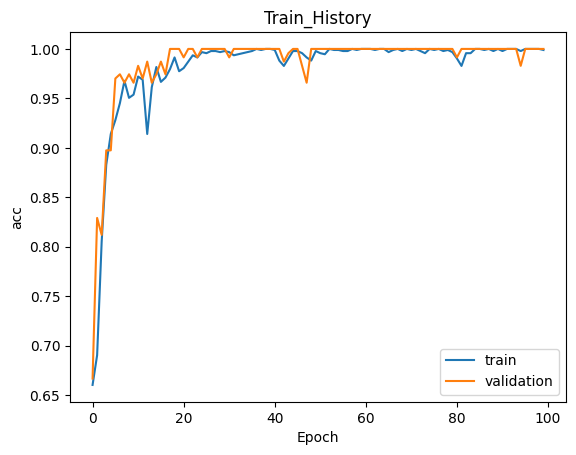

In [88]:
now_str = datetime.datetime.now()
now_str = datetime.datetime.strftime(now_str, '%Y%m%d_%H%M%S')

def show_train_history(train_history, train, validation):
    # 定義show_train_history函數，輸入下列參數:之前訓練過程所產生的train_history、
    # ...訓練資料的執行結果、驗證資料的執行結果
    print(train_history.history)
    plt.style.use('default')
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train_History')  # 顯示圖的標題
    plt.ylabel(train)  # 顯示y軸的標籤
    plt.xlabel('Epoch')  # 設定x軸標籤是'Epoch'
    plt.legend(['train', 'validation'], loc='best')
    # 設定國例是顯示'train', 'validation',位置在左上角

    train_history_path = os.path.join(now_path, 'train_history', Tr_ver)
    os.makedirs(train_history_path, exist_ok=True)

    plt.savefig(os.path.join(train_history_path, now_str + '_' + train + '.png'), bbox_inches='tight', pad_inches=0)

    plt.show()

show_train_history(train_history, 'loss', 'val_loss')
show_train_history(train_history, 'acc', 'val_acc')
# show_train_history(train_history, 'accuracy', 'val_accuracy')

In [89]:
scores = model.evaluate(test_value_4D, test_label_OneHot)
print('loss=', scores[0], '\nacc=', scores[1])

f = open(os.path.join(now_path, 'train_history', 'train_history.txt'), 'a+')  # a+

content = f.read()
f.seek(0, 0)

f.write('\n' + '---------------------------------' + '\n')
f.write('\n' + '*****' + Tr_ver + '*****' + '\n')
f.write(now_str + '\n')
f.write('loss=' + '\n' + str(scores[0]) + '\n')
f.write('acc=' + '\n' + str(scores[1]))

f.write('\n' + content)
f.close()

75/75 [==============================] - 0s 613us/sample - loss: 2.3316e-06 - acc: 1.0000
loss= 2.3315846920013428e-06 
acc= 1.0


In [90]:
# 使用pd.crosstab建立混淆矩陣，輸入下列參數:
prediction = model.predict_classes(test_value_4D)
pd.crosstab(test_label,  # 測試資料數字影像的其實值
            prediction,  # 測試資料數字影像的預測結果
            rownames=['label'],  # 設定行的名稱是label
            colnames=['predict'])  # 設定列的名稱是predict

predict,0,1,2
label,,,
0,32,0,0
1,0,31,0
2,0,0,12


In [91]:
MWpath = os.path.join(now_path, '..\..', 'model_weight')
os.makedirs(MWpath, exist_ok=True)
Wver = now_path.split('\\')[-1]
model.save(os.path.join(MWpath, Tr_ver + 'SoundWeight_' + Wver + '_type2.h5'))